# Appendix: Transmission Line Modelling

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Recursive function to compute overall impedance for given transmission line (this function can also be imported from taufactor/utils with `from taufactor.utils import compute_impedance`)

In [2]:
def compute_impedance(R, C, freq):
    """Compute impedance given resistor and capacitor arrays."""
    Z = np.full_like(freq, 1e50, dtype=complex)
    for R_i, C_i in zip(R[::-1], C[::-1]):
        Z = R_i + 1.0 / (1j * freq * C_i + 1.0 / Z)
    return Z

## Comparison of discrete with analytical solution

This example shows that
1. A change in the capacitance constant does not alter the impedance (just the frequencies which are relevant)
2. A change in resistance scales both the real and imaginary part
3. The relative error between the analytical and discrete solution goes to zero as the number of elements is increased (as expected)
4. We should use the discrete solution as a reference for impedance simulations to minimize the error from post-processing

Deviation of -7.0854 %
Deviation of -2.9318 %
Deviation of -1.4828 %


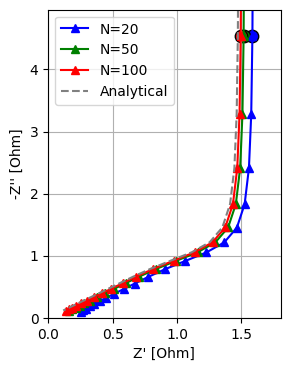

In [3]:
L = 2
conductivity = 0.45 # [S/m] = [1/Ohm m]
capacitance = 0.19  # [F/m^2] = [C/V m^2]
area = 1 # cross-sectional area [m^2]
surf = 0.11 # specific surface area [1/m]

# Resistivity and capacitance per length 
r_x = 1/conductivity/area   # [Ohm / m]
c_x = capacitance*surf*area # [F / m]

freq_0 = 1 / r_x / c_x / L**2
freq = freq_0 * 2 ** np.arange(-3, 10, 0.5)
lambdas_0 = np.sqrt(1j * freq * r_x * c_x)
Z_pde_ref = r_x * np.cosh(lambdas_0*L) / np.sinh(lambdas_0*L) / lambdas_0

fig, ax = plt.subplots(figsize=(3, 4), dpi=100)
colors = ['b', 'g', 'r']
for i, N_el in enumerate([20, 50, 100]):
    # Discrete resistance and capacitance
    R_i = r_x * L / N_el
    C_i = c_x * L / N_el

    Z_mean = compute_impedance(R_i*np.ones(N_el), C_i*np.ones(N_el), freq)
    print(f"Deviation of {100*(Z_pde_ref[0].real-Z_mean[0].real)/Z_mean[0].real:.4f} %")
    plt.plot(Z_mean.real, -Z_mean.imag, '^-', color=colors[i], label=f'N={N_el}')
    ref_idx = np.argmin(np.abs(freq - freq_0))
    plt.scatter(Z_mean.real[ref_idx], -Z_mean.imag[ref_idx], c=colors[i], edgecolors='k', s=80)
ax.plot(Z_pde_ref.real, -Z_pde_ref.imag, label='Analytical', color='gray', linestyle='--')
plt.xlabel("Z' [Ohm]")
plt.ylabel("-Z'' [Ohm]")
# plt.title("Nyquist Plot")
# ax.set_aspect('equal')
plt.legend()
plt.grid()
plt.xlim([0, 1.2*Z_mean[0].real])
plt.ylim([0, 3*1.1*Z_mean[0].real])
plt.show()


## Heterogenous distribution of impedance

The three microstructural parameters
- porosity $\epsilon(x)$,
- specific surface area $a(x)$ and
- tortuosity factor $\tau(x)$
all determine the effective behaviour of on electrode.
One way of quantifiying this as a scalar factor is the tortuosity factor extracted from impedance measurements $\tau_\text{EIS}$ which can be described as:

How much **harder or easier** is it to **transport ions to all reactive surfaces** compared to a perfectly homogeneous electrode with straight channels and the
- same dimensions (thickness of electrode $L$ and cross-sectional area $A$),
- same overall porosity $\bar{\epsilon}=(\int \epsilon(x))/L$ and
- same average specific surface area $\bar{a}=(\int a(x))/L$.

$\tau_\text{EIS} > 1$ indicates worse than homogeneous case while $\tau_\text{EIS} < 1$ means better than the homogeneous reference.
As we are only interested in the non-dimensional tortuosity factor, we can select the physical parameters such that we ensure high numerical accuracy and normalize the impedance with respect to the analytical solution. Therefore, we set the physical parameters `conductivity=1`, `capacitance=1` and `area=1` in the following.

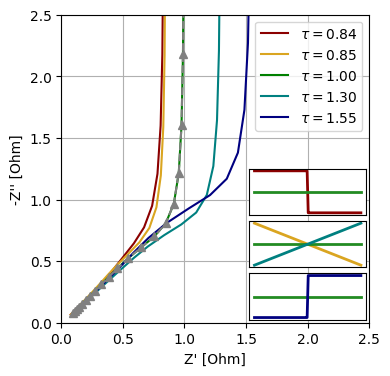

In [4]:
def plot_nyquist(Zs, Z_mean, freq, ref_freq=None):
    """Plot Nyquist plot comparing heterogeneous and homogenized impedance."""
    scale = Z_mean[0].real
    ax_lim = 1.0
    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    colors = ['darkred', 'goldenrod', 'green', 'teal',  'navy']
    for i, Z in enumerate(Zs):
        ax_lim = np.max([Z[0].real/scale, ax_lim])
        plt.plot(Z.real/scale, -Z.imag/scale, color=colors[i] , label=f'$\\tau=${Z[0].real/Z_mean[0].real:.2f}')
    plt.plot(Z_mean.real/scale, -Z_mean.imag/scale, '^', color='gray', linestyle='--') #, label='Homogenized reference')

    # Mark a reference frequency point (optional)
    if ref_freq:
        ref_idx = np.argmin(np.abs(freq - ref_freq))
        for i, Z in enumerate(Zs):
            plt.scatter(Z.real[ref_idx]/scale, -Z.imag[ref_idx]/scale, c=colors[i], edgecolors='k', s=80)
        plt.scatter(Z_mean.real[ref_idx]/scale, -Z_mean.imag[ref_idx]/scale, c='blue', edgecolors='k', s=80)

    plt.xlabel("Z' [Ohm]")
    plt.ylabel("-Z'' [Ohm]")
    ax.set_aspect('equal')
    plt.legend()
    plt.grid()
    plt.xlim([0, 2.5])
    plt.ylim([0, 2.5])
    # plt.show()
    return fig, ax

# Set parameters
N_el = 100
tau_x = np.linspace(1.0, 1.0, N_el)
step1 = np.concatenate((np.linspace(0.7, 0.7, int(N_el/2)), np.linspace(0.3, 0.3, int(N_el/2))))
lin1  = np.linspace(0.7, 0.3, N_el)
hom   = np.linspace(0.5, 0.5, N_el)
lin2  = np.linspace(0.3, 0.7, N_el)
step2 = step1[::-1].copy()

# Compute impedance for heterogeneous distribution
freq_0 = np.mean(hom) / np.mean(hom) / N_el**2
freq = freq_0 * 2 ** np.arange(-3, 10, 0.5)  # Frequency array
Zs = []
for eps_x in [step1, lin1, hom, lin2, step2]:
# for a_x in [step1, lin1, hom, lin2, step2]:
    # eps_x = hom
    a_x = hom
    R = tau_x/eps_x
    C = a_x
    Zs.append(compute_impedance(R, C, freq))

# Compute impedance for homogenized case
R_mean = np.full(N_el, 1/np.mean(hom))
C_mean = np.full(N_el, np.mean(hom))
Z_mean = compute_impedance(R_mean, C_mean, freq)

# for Z in Zs:
#     print(f"tau_e = {Z[0].real/Z_mean[0].real:.4f}")
# Plot Nyquist plots
fig, ax = plot_nyquist(Zs, Z_mean, freq, ref_freq = freq_0)

colors = ['darkred', 'goldenrod', 'forestgreen', 'teal', 'navy']
axins = ax.inset_axes([0.61, 0.35, 0.38, 0.15])
axins.plot(np.arange(N_el), step1, color=colors[0], linewidth=2)
axins.plot(np.arange(N_el), hom, color=colors[2], linewidth=2)
axins.set_xticks([])
axins.set_yticks([])

axins = ax.inset_axes([0.61, 0.18, 0.38, 0.15])
axins.plot(np.arange(N_el), lin1, color=colors[1], linewidth=2)
axins.plot(np.arange(N_el), hom, color=colors[2], linewidth=2)
axins.plot(np.arange(N_el), lin2, color=colors[3], linewidth=2)
axins.set_xticks([])
axins.set_yticks([])

axins = ax.inset_axes([0.61, 0.01, 0.38, 0.15])
axins.plot(np.arange(N_el), hom, color=colors[2], linewidth=2)
axins.plot(np.arange(N_el), step2, color=colors[4], linewidth=2)
axins.set_xticks([])
axins.set_yticks([])
plt.show()

**Some important conclusions are:**

The impedance measurement alone is not conclusive. Note that an even distribution of resistance (i.e. same volume fraction and tortuosity throughout the electrode thickness) in combination with a grading in specific surface area still leads to $\tau_\text{EIS} \neq 1$. This means transport appears to be better/worse simply because there is more/less surface area close to the separator side.

## Downsampling for DFN models

Let's assume we have determined the averaged properties $\epsilon(x)$, $a_\text{surf}(x)$ and $\tau(x)$ from a micrograph with a resolution of 200 voxels in x-direction (the direction of ion transport in the porous electrode). To transfer these values into a DFN battery cell model such as PyBAMM, we need to reduce the amount if grid points.

Deviation of -3.8797 %


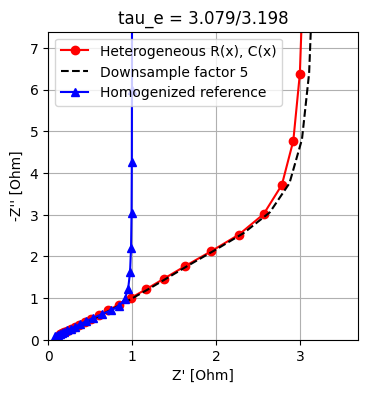

In [5]:
N_el = 200
eps_x = np.linspace(0.7, 0.1, N_el)
tau_x = np.linspace(1.0, 5.0, N_el)
a_x   = np.linspace(1, 10, N_el)

# Compute impedance for heterogeneous distribution
R = tau_x/eps_x
C = a_x
freq_0 = np.mean(eps_x) / np.mean(C) / N_el**2
freq = freq_0 * 2 ** np.arange(-3, 10, 0.5) 
Z = compute_impedance(R, C, freq)

# Compute impedance for homogenized case
R_mean = np.full(N_el, 1/np.mean(eps_x))
C_mean = np.full(N_el, np.mean(C))
Z_mean = compute_impedance(R_mean, C_mean, freq)

# Compute impedance for downsampled case
def coarse_grain_ladder(R, C, m):
    M = len(R) // m
    Rb = R[:M*m].reshape(M, m).sum(axis=1)  # add series resistances
    Cb = C[:M*m].reshape(M, m).sum(axis=1)  # add surface areas
    return Rb, Cb

factor = 5
R_d, C_d = coarse_grain_ladder(R, C, factor)
Z_d = compute_impedance(R_d, C_d, freq)

print(f"Deviation of {100*(Z[0].real-Z_d[0].real)/Z[0].real:.4f} %")
# Plot Nyquist plots
scale = Z_mean[0].real
ax_lim = 1.2*np.max([Z[0].real, Z_mean[0].real])/scale
plt.figure(figsize=(4, 4), dpi=100)
plt.plot(Z.real/scale, -Z.imag/scale, 'ro-', label='Heterogeneous R(x), C(x)')
plt.plot(Z_d.real/scale, -Z_d.imag/scale, color='black', linestyle='--', label=f'Downsample factor {factor}')
plt.plot(Z_mean.real/scale, -Z_mean.imag/scale, 'b^-', label='Homogenized reference')

plt.xlabel("Z' [Ohm]")
plt.ylabel("-Z'' [Ohm]")
plt.title(f"tau_e = {Z[0].real/Z_mean[0].real:.3f}/{Z_d[0].real/Z_mean[0].real:.3f}")
plt.legend()
plt.grid()
plt.xlim([0, ax_lim])
plt.ylim([0, 2*ax_lim])
plt.show()

Note that summing resistances and capacitance in the above case relates to microstructural parameters in the following way:
Let $i$ be the index on the fine grid and $f$ the coarsening factor. Properties on the coarse grid indexed by $k$ are then given as

- $\epsilon_k = \sum^f_i \epsilon_i / f$ (arithmetic mean)
- $a_k = \sum^f_i a_i / f$ (arithmetic mean)
- $\tau_k = (\sum^f_i \tau_i / \epsilon_i)/ f * \epsilon_k$

which recovers the summation of resistances and capacitance
- $C_k = \sum_i^f C_i = c_{dl}A_c \sum_i a_i \Delta x = c_{dl}A_c a_k f\Delta x$
- $R_k = \sum_i^f R_i= \sum_i^f \tau_i\Delta x/(\epsilon_i\sigma_0 A_c) = f \tau_k/\epsilon_k$

The averaging scheme for $\tau$ is consistent with taking the harmonic mean of effective diffusivities/ conductivities.